In [2]:
# App Review Analysis

# This notebook performs:
# 1. App review scraping
# 2. Sentiment analysis and visualization
# 3. Categorization of reviews and frequency visualization
# 4. Word cloud generation for frequent word analysis

# ------------------------------------------------------------------------

# Step 1: Install Required Libraries
# ------------------------------------------------------------------------

# Install the necessary libraries for scraping, sentiment analysis, categorization, and visualization.
# You only need to run this once if these libraries are not already installed.

!pip install app-store-scraper pandas torch transformers matplotlib requests seaborn wordcloud scikit-learn
!pip install openai==0.28
!pip install --upgrade urllib3 six
# ------------------------------------------------------------------------



  Using cached urllib3-1.25.11-py2.py3-none-any.whl.metadata (41 kB)
Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
Using cached urllib3-2.2.3-py3-none-any.whl (126 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 2.2.3 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Step 2: App Review Scraping
# ------------------------------------------------------------------------

import json
import pandas as pd
from datetime import datetime
from app_store_scraper import AppStore
import time

# Scraping app reviews from the Apple App Store
def scrape_reviews(app_name, app_id, total_reviews, batch_size=100):
    app = AppStore(country="us", app_name=app_name, app_id=app_id)
    all_reviews = []
    total_fetched = 0
    
    while total_fetched < total_reviews:
        app.review(how_many=batch_size)
        if not app.reviews:
            break
        all_reviews.extend(app.reviews)
        total_fetched += len(app.reviews)
        print(f"Fetched {len(app.reviews)} reviews, total so far: {total_fetched}")
        time.sleep(1)

    # Convert datetime fields to strings
    for review in all_reviews:
        if isinstance(review['date'], datetime):
            review['date'] = review['date'].isoformat()

    return pd.DataFrame(all_reviews)

# Scrape reviews and save to CSV
df_reviews = scrape_reviews("tuya-smart", 1034649547, total_reviews=200)
df_reviews.to_csv('tuya_reviews_200.csv', index=False)
print(f"Saved {len(df_reviews)} reviews to 'tuya_reviews_200.csv' as a DataFrame.")

# ------------------------------------------------------------------------

c:\Users\hcwu2\AppData\Local\Programs\Python\Python312\Lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2024-10-10 22:38:06,193 [INFO] Base - Initialised: AppStore('us', 'tuya-smart', 1034649547)
2024-10-10 22:38:06,194 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/tuya-smart/id1034649547
2024-10-10 22:38:08,492 [INFO] Base - [id:1034649547] Fetched 100 reviews (100 fetched in total)


Fetched 100 reviews, total so far: 100


2024-10-10 22:38:11,625 [INFO] Base - [id:1034649547] Fetched 100 reviews (200 fetched in total)


Fetched 200 reviews, total so far: 300
Saved 300 reviews to 'tuya_reviews_200.csv' as a DataFrame.


2024-10-10 22:58:34,577 [INFO] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-10 22:58:34,587 [INFO] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\hcwu2\AppData\Local\Temp\ipykernel_22136\1675639034.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(rating_over_time['year_month'].astype(str), rotation=45, ha='right')
2024-10-10 22:58:34,646 [INFO] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type b

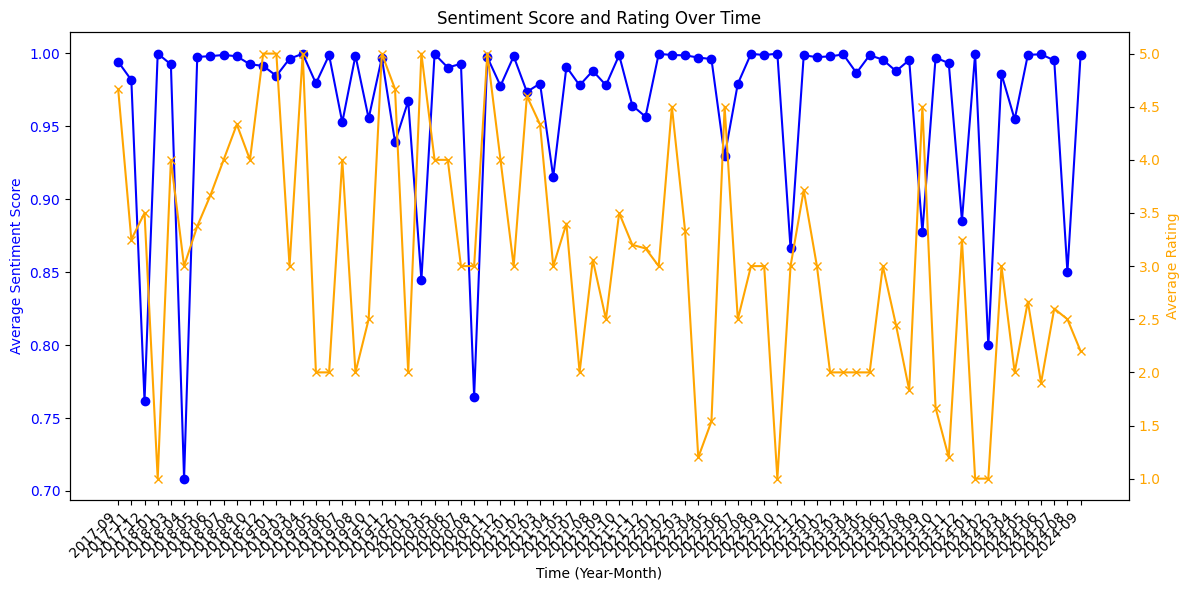

In [5]:
# Step 3: Sentiment Analysis and Visualization
# ------------------------------------------------------------------------

from transformers import pipeline
import matplotlib.pyplot as plt

# Sentiment analysis using a pre-fine-tuned DistilBERT model
def perform_sentiment_analysis(df):
    sentiment_analysis = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    
    def get_sentiment(review_text):
        result = sentiment_analysis(review_text)[0]
        return result['label'], result['score']
    
    df[['sentiment', 'sentiment_score']] = df['review'].apply(lambda x: pd.Series(get_sentiment(x)))
    return df

# Visualize sentiment score and rating over time
def visualize_sentiment_and_rating(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = df['date'].dt.to_period('M')
    rating_over_time = df.groupby('year_month').agg({'rating': 'mean', 'sentiment_score': 'mean'}).reset_index()
    
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    # Sentiment score plot
    ax1.set_xlabel('Time (Year-Month)')
    ax1.set_ylabel('Average Sentiment Score', color='blue')
    ax1.plot(rating_over_time['year_month'].astype(str), rating_over_time['sentiment_score'], marker='o', color='blue', label='Sentiment Score')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticklabels(rating_over_time['year_month'].astype(str), rotation=45, ha='right')
    
    # Rating plot
    ax2 = ax1.twinx()
    ax2.set_ylabel('Average Rating', color='orange')
    ax2.plot(rating_over_time['year_month'].astype(str), rating_over_time['rating'], marker='x', color='orange', label='Rating')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    plt.title('Sentiment Score and Rating Over Time')
    fig.tight_layout()
    plt.show()

# Perform sentiment analysis and visualization
df_reviews = perform_sentiment_analysis(pd.read_csv('tuya_reviews_200.csv'))
visualize_sentiment_and_rating(df_reviews)

# ------------------------------------------------------------------------

In [9]:
# Step 4: Categorization and Visualization
# ------------------------------------------------------------------------

import openai
import os
import seaborn as sns

# Categorize app reviews using GPT-4
import openai
import time

def categorize_reviews(df, batch_size=2):
    openai_api_key = os.getenv("openai_api_key")
    openai.api_key = openai_api_key
    prompt_template = """
    You are an AI designed to categorize app reviews based on both the title and content. The categories are:
    - User Interface and Design
    - Feature Requests
    - Usability Issues
    - App Stability and Reliability
    - Performance Feedback
    - Security and Privacy
    - Notifications and Alerts
    - Customer Support
    - Subscription and Pricing
    - Localization and Language Support
    - Positive Feedback (Kudos)
    Title: {title}
    Review: {review}
    Categories (comma-separated if more than one):
    """
    
    def get_categories_in_batch(titles, reviews):
        responses = []
        for title, review in zip(titles, reviews):
            prompt = prompt_template.format(title=title, review=review)
            
            while True:
                try:
                    # Send the request to GPT-4
                    response = openai.ChatCompletion.create(
                        model="gpt-4",
                        messages=[{"role": "system", "content": "You are an AI designed to categorize app reviews."},
                                  {"role": "user", "content": prompt}],
                        max_tokens=100,
                        temperature=0
                    )
                    categories = response['choices'][0]['message']['content'].strip()
                    responses.append(categories.split(', '))
                    break  # Exit the loop if successful
                except openai.error.RateLimitError:
                    # If rate limit is hit, wait before retrying
                    print("Rate limit reached. Waiting 60 seconds before retrying...")
                    time.sleep(60)
                except Exception as e:
                    # Catch any other errors
                    print(f"Error: {e}")
                    time.sleep(10)
        return responses

    categories = []
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_categories = get_categories_in_batch(batch_df['title'].tolist(), batch_df['review'].tolist())
        categories.extend(batch_categories)

    df['category'] = categories
    return df

# Create binary columns for each category
def create_binary_labels(df, all_categories):
    for category in all_categories:
        df[category] = df['category'].apply(lambda x: 1 if category in x else 0)
    return df

# Visualize category frequency
def visualize_category_frequency(df, all_categories):
    category_counts = df[all_categories].sum()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title('Frequency of Each Category (Binary Labels)')
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Perform categorization and visualization
all_categories = [
    'User Interface and Design', 'Feature Requests', 'Usability Issues',
    'App Stability and Reliability', 'Performance Feedback', 'Security and Privacy',
    'Notifications and Alerts', 'Customer Support', 'Subscription and Pricing',
    'Localization and Language Support', 'Positive Feedback (Kudos)'
]
df_reviews = categorize_reviews(df_reviews)
df_reviews = create_binary_labels(df_reviews, all_categories)
visualize_category_frequency(df_reviews, all_categories)

# ------------------------------------------------------------------------

2024-10-10 23:14:48,822 [INFO] openai - error_code=rate_limit_exceeded error_message='Rate limit reached for gpt-4 in organization org-uQLi7fFXV35l8oSGXToLnLNb on tokens per min (TPM): Limit 10000, Used 9560, Requested 509. Please try again in 414ms. Visit https://platform.openai.com/account/rate-limits to learn more.' error_param=None error_type=tokens message='OpenAI API error received' stream_error=False


Rate limit reached. Waiting 60 seconds before retrying...


KeyboardInterrupt: 

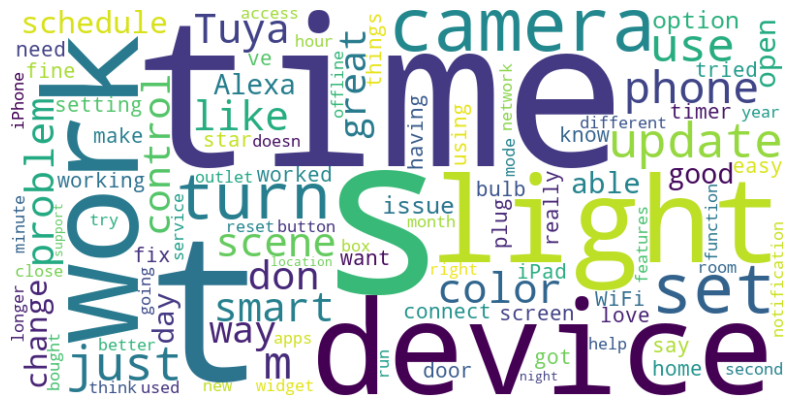

In [10]:
# Step 5: Word Cloud Generation
# ------------------------------------------------------------------------

from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Generate word cloud from reviews
def generate_word_cloud(df):
    all_reviews_text = ' '.join(df['review'])
    stopwords = set(ENGLISH_STOP_WORDS)
    custom_stopwords = {'app', 'review', 'feature', 'product', 'does', 'goes', 'thing'}
    stopwords.update(custom_stopwords)
    
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        colormap='viridis',
        collocations=False
    ).generate(all_reviews_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud
generate_word_cloud(df_reviews)